In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.stage2 import generate_2nd_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["2nd_stage"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['2nd_stage']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-12 19:25:58.182145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-12 19:25:58.615163: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-12 19:26:00.122881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_080


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")
train, features = generate_2nd_stage_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [07:47<00:00,  1.69s/it]


,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,anglez_diff_abs_rolling_median_10,...,anglez_mean_rolling_median_1000_shift_416,enmo_mean_rolling_median_1000_shift_416,anglez_rolling_square_mean_1000_shift_416,enmo_rolling_square_mean_1000_shift_416,anglez_diff_abs_rolling_square_mean_1000_shift_416,enmo_diff_abs_rolling_square_mean_1000_shift_416,anglez_mean_rolling_square_mean_1000_shift_416,enmo_mean_rolling_square_mean_1000_shift_416,reduce_step,fold
283,16.702658,38.064583,51.115900,84.6226,51.115900,15.962638,11.263916,8.043460,12.792510,14.257165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6803,3
284,7.195825,28.564683,51.115900,84.6226,51.115900,8.541195,12.527601,7.737612,12.364961,6.165692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6827,3
285,16.351179,34.583987,51.115900,84.6226,40.295400,15.494380,12.499973,7.288104,12.204054,14.248077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6851,3
286,10.855896,32.284983,42.890471,84.6226,38.495083,10.967216,12.269771,6.938846,12.743385,6.737581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6875,3
287,11.523954,27.963821,43.971200,84.6226,41.090162,12.171813,13.303702,6.618652,12.236429,10.896129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6899,3


(877617, 1382)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG["2nd_stage"]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.72168
[100]	eval-rmse:0.95520
[200]	eval-rmse:0.95274
[300]	eval-rmse:0.95204
[400]	eval-rmse:0.95065
[500]	eval-rmse:0.95213
[531]	eval-rmse:0.95294


 20%|██        | 1/5 [00:49<03:17, 49.35s/it]

== fold 1 ==
[0]	eval-rmse:1.61245
[100]	eval-rmse:0.91567
[200]	eval-rmse:0.91145
[300]	eval-rmse:0.91544


 40%|████      | 2/5 [01:27<02:07, 42.53s/it]

== fold 2 ==
[0]	eval-rmse:1.64923
[100]	eval-rmse:0.95364
[200]	eval-rmse:0.95302
[234]	eval-rmse:0.95335


 60%|██████    | 3/5 [01:59<01:16, 38.11s/it]

== fold 3 ==
[0]	eval-rmse:1.62008
[100]	eval-rmse:0.89580
[200]	eval-rmse:0.89335
[241]	eval-rmse:0.89506


 80%|████████  | 4/5 [02:31<00:35, 35.39s/it]

== fold 4 ==
[0]	eval-rmse:1.69496
[100]	eval-rmse:0.95964
[200]	eval-rmse:0.96164
[227]	eval-rmse:0.96294


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.72312
[100]	eval-rmse:0.95091
[200]	eval-rmse:0.94745
[300]	eval-rmse:0.94750
[310]	eval-rmse:0.94761


 20%|██        | 1/5 [00:30<02:01, 30.26s/it]

== fold 1 ==
[0]	eval-rmse:1.61064
[100]	eval-rmse:0.92324
[200]	eval-rmse:0.92537
[221]	eval-rmse:0.92876


 40%|████      | 2/5 [01:02<01:34, 31.65s/it]

== fold 2 ==
[0]	eval-rmse:1.65728
[100]	eval-rmse:0.95606
[191]	eval-rmse:0.95673


 60%|██████    | 3/5 [01:32<01:01, 30.68s/it]

== fold 3 ==
[0]	eval-rmse:1.62209
[100]	eval-rmse:0.94921
[181]	eval-rmse:0.95035


 80%|████████  | 4/5 [02:03<00:30, 30.91s/it]

== fold 4 ==
[0]	eval-rmse:1.68978
[100]	eval-rmse:0.97304
[200]	eval-rmse:0.97111
[300]	eval-rmse:0.96992
[400]	eval-rmse:0.97034
[417]	eval-rmse:0.97075


100%|██████████| 5/5 [02:51<00:00, 34.28s/it]


## Dynamic-Range NMS

<AxesSubplot: >

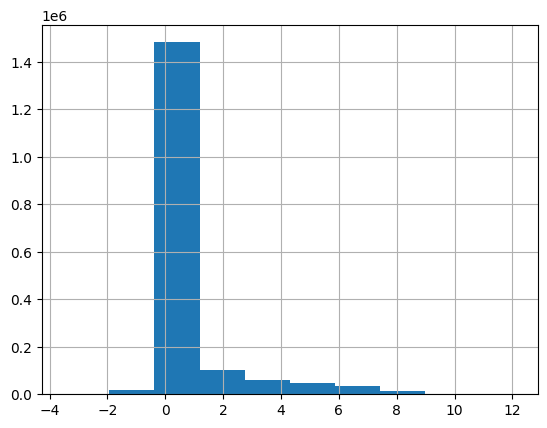

In [4]:
train["score"].hist()

In [5]:
train = train[train["score"] > 0.1]

In [6]:
import scipy
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np

score2range = scipy.interpolate.interp1d([-100, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100], [0, 0, 12, 36, 60, 90, 120, 150, 180, 240, 300, 360, 360])
range2score = scipy.interpolate.interp1d([0, 12, 36, 60, 90, 120, 150, 180, 240, 300, 360], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
score2range(1.5)

def process_group(df):
    dfs = []
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    used = np.zeros(len(df))
    reduce_rate = np.ones(df["step"].max() + 500)
    for _ in range(len(df)):
        best_score = -1e10
        best_idx = -1
        best_step = -1
        best_row = -1
        for i, row in df.iterrows():
            if used[i]:
                continue
            score = row["score"] / reduce_rate[row["step"]]
            if score > best_score:
                best_score = score
                best_idx = i
                best_step = row["step"]
                row["reduced_score"] = score
                best_row = row
        dfs.append(best_row)
        used[best_idx] = True

        range_ = score2range(best_score)
        for r in range(1, int(range_)):
            reduce = range2score(range_ - r) + 1
            reduce_rate[best_step + r] = max(reduce_rate[best_step + r], reduce)
            if best_step - r >= 0:
                reduce_rate[best_step - r] = max(reduce_rate[best_step - r], reduce)
    return dfs

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(process_group, groups), total=len(groups)))
all_results = [item for sublist in results for item in sublist]
sub = pd.DataFrame(all_results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [33:29<00:00,  7.26s/it]  


In [7]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7125


event   tolerance
onset   12           0.110789
        36           0.465851
        60           0.679687
        90           0.777703
        120          0.810383
        150          0.825383
        180          0.834987
        240          0.844375
        300          0.851741
        360          0.857183
wakeup  12           0.119775
        36           0.506401
        60           0.696915
        90           0.783156
        120          0.815126
        150          0.827777
        180          0.841412
        240          0.855677
        300          0.868081
        360          0.877395
dtype: float64